In [1]:
#import needed libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from tensorflow import keras
from keras.models import load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.preprocessing import image
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout

from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix

import os



**To split into train test and validate folders I am going to use this library**

In [3]:
pip install split-folders --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.


In [11]:
import splitfolders
splitfolders.ratio("../input/flowers-recognition/flowers",output="Tr-Te-Val",ratio=(0.8,0.1,0.1))

Copying files: 4326 files [00:06, 638.89 files/s] 


In [12]:
os.removedirs("./Tr-Te-Val/train/flowers")
os.removedirs("./Tr-Te-Val/test/flowers")
os.removedirs("./Tr-Te-Val/val/flowers")

**Image data from the folders using Image Data Generator**

In [13]:
train_gen = Imgen(preprocessing_function=keras.applications.densenet.preprocess_input,
                 zoom_range=0.2,
                  shear_range=0.2,
                  vertical_flip=True,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  fill_mode='nearest'
                 )

val_gen = Imgen(preprocessing_function=keras.applications.densenet.preprocess_input,
                 zoom_range=0.2,
                  shear_range=0.2,
                  vertical_flip=True,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  fill_mode='nearest'
                 )

test_gen = Imgen(preprocessing_function=keras.applications.densenet.preprocess_input
                 )

In [14]:
train_ds = train_gen.flow_from_directory("./Tr-Te-Val/train",
                                       target_size=(331,331),
                                        seed = 123,
                                        batch_size=32
                                       )

val_ds = val_gen.flow_from_directory("./Tr-Te-Val/val",
                                       target_size=(331,331),
                                        seed = 123,
                                        batch_size=32)

test_ds = test_gen.flow_from_directory("./Tr-Te-Val/test",
                                       target_size=(331,331),
                                        seed = 123,
                                        batch_size=32,
                                      shuffle=False
                                      )

Found 3457 images belonging to 5 classes.
Found 430 images belonging to 5 classes.
Found 436 images belonging to 5 classes.


**Getting the name of classes for ease of use**

In [15]:
a = train_ds.class_indices
classes = list(a.keys())
classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

**Extracting one batch from datagen for visualization purposes**

In [16]:
#one batch
X,Y = next(train_ds)

In [17]:
#plot function
def plot_images(img,labels):
    plt.figure(figsize=(15,10))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(img[i])
        plt.title(classes[np.argmax(labels[i])])
        plt.axis('off')

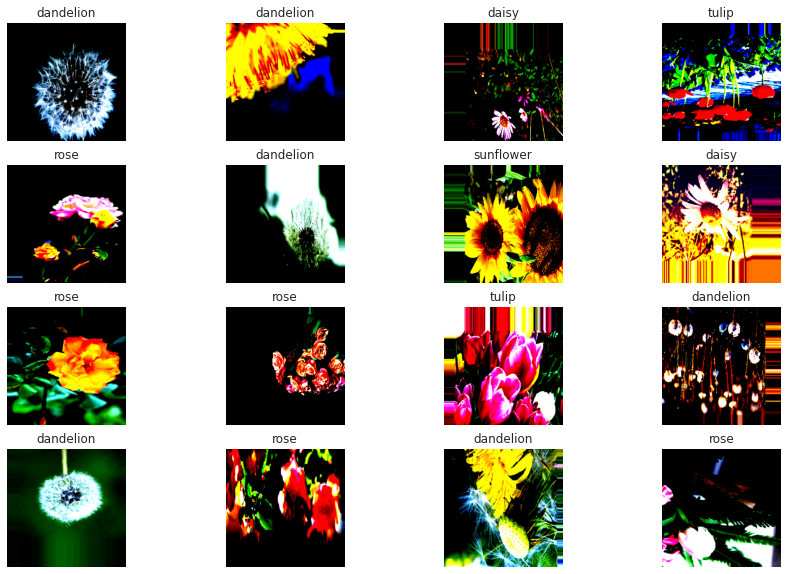

In [18]:
plot_images(X,Y)

## **Using Transfer Learning to build the Model**

In [19]:
from keras.applications.densenet import DenseNet201

In [20]:
base_model = DenseNet201(include_top=False,
                  input_shape=(331,331,3),
                   weights = 'imagenet',
                    pooling='avg'
                  )
base_model.trainable = False

74842112/74836368 [==============================] - 4s 0us/step


In [21]:
inputs = base_model.input
l1 = Dense(128,activation='relu')(base_model.output)
outputs = Dense(5,activation='softmax')(l1)
model = keras.Model(inputs=inputs,outputs=outputs)

In [22]:
#compile 
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

**Defining callbacks to get the best model possible**

In [23]:
#callbacks
my_calls = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=3),
            keras.callbacks.ModelCheckpoint("Model.h5",verbose=1,save_best_only=True)]

**Training**

In [24]:
hist = model.fit(train_ds,epochs=18,validation_data=val_ds,callbacks=my_calls)

Epoch 1/18
109/109 [==============================] - 135s 1s/step - loss: 0.8191 - accuracy: 0.6936 - val_loss: 0.6233 - val_accuracy: 0.7977

Epoch 00001: val_loss improved from inf to 0.62328, saving model to Model.h5
Epoch 2/18
109/109 [==============================] - 112s 1s/step - loss: 0.3910 - accuracy: 0.8582 - val_loss: 0.4369 - val_accuracy: 0.8419

Epoch 00002: val_loss improved from 0.62328 to 0.43693, saving model to Model.h5
Epoch 3/18
109/109 [==============================] - 112s 1s/step - loss: 0.2758 - accuracy: 0.9018 - val_loss: 0.3499 - val_accuracy: 0.8628

Epoch 00003: val_loss improved from 0.43693 to 0.34990, saving model to Model.h5
Epoch 4/18
109/109 [==============================] - 112s 1s/step - loss: 0.2193 - accuracy: 0.9262 - val_loss: 0.3174 - val_accuracy: 0.8721

Epoch 00004: val_loss improved from 0.34990 to 0.31742, saving model to Model.h5
Epoch 5/18
109/109 [==============================] - 112s 1s/step - loss: 0.2294 - accuracy: 0.9113 - v

**Getting the saved model**

In [25]:
model = load_model("./Model.h5")

In [26]:
#test
model.evaluate(test_ds)

14/14 [==============================] - 8s 329ms/step - loss: 0.2306 - accuracy: 0.9335


[0.23061896860599518, 0.9334862232208252]

**Graphs to show loss and accuracy along the training**

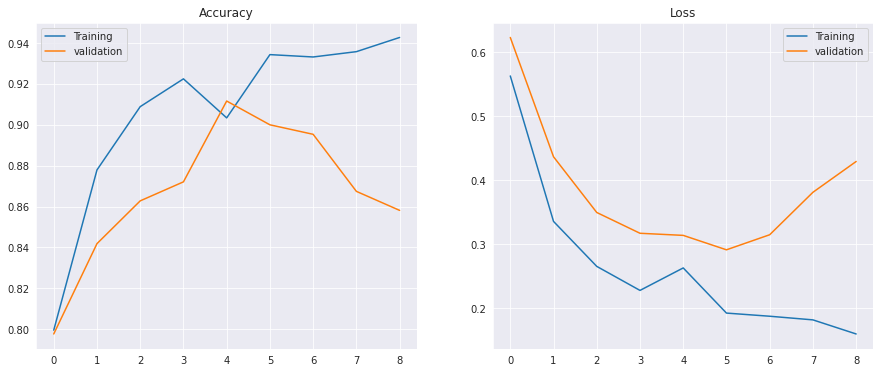

In [27]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

**Making Predictions and Verifying**

In [28]:
preds = model.predict(test_ds,verbose=1)

14/14 [==============================] - 7s 240ms/step


In [29]:
pred = [np.argmax(i) for i in preds]
pred[:5]

[1, 0, 0, 0, 0]

In [30]:
actual = test_ds.classes

**Classification Report**

In [31]:
print(classification_report(pred,actual))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94        79
           1       0.95      0.93      0.94       109
           2       0.92      0.92      0.92        79
           3       0.96      0.96      0.96        74
           4       0.89      0.93      0.91        95

    accuracy                           0.93       436
   macro avg       0.93      0.93      0.93       436
weighted avg       0.93      0.93      0.93       436



**Confusion Matrix**

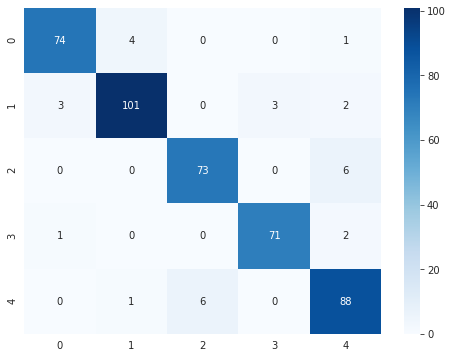

In [32]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(pred,actual),annot = True, fmt = 'd', cmap = 'Blues');

**Individual image Identification**

> function to predict

In [33]:
def predict_img(path):
    img = image.load_img(path,target_size=(331,331))
    img_arr = image.img_to_array(img)
    img_arr_expnd  = np.expand_dims(img_arr,axis=0)
    img = keras.applications.densenet.preprocess_input(img_arr_expnd)
    
    pred = model.predict(img)
    result = classes[np.argmax(pred)]
    
    return result

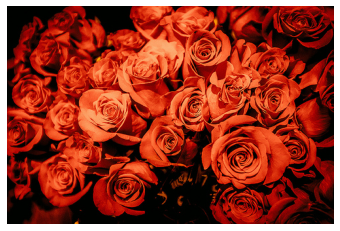

In [34]:
plt.imshow(Image.open("../input/flowers-recognition/flowers/rose/10503217854_e66a804309.jpg"))
plt.axis('off');

**Prediction**

In [35]:
print("The given image belongs to class:",predict_img("../input/flowers-recognition/flowers/rose/10503217854_e66a804309.jpg"))

The given image belongs to class: rose
